From the Kaggle web site (https://www.kaggle.com/datasets) download the Suicide Rates Overview 1985 to 2016 dataset. This dataset has 12 features and 27820 data points. In this assignment we would like to develop a machine learned model to predict, given some feature vectors, if the outcome would be suicide or not, as a binary dependent variable. The binary categories could be {"low suicide rate", "high suicide rate"}. (Note that a different approach could seek to generate a numerical value by solving a regression problem.) 

A machine learning solution would require us to pre-process the dataset and prepare/design our experimentation. 
Load the dataset in your model development framework (Jupyter notebook) and examine the features. Note that the Kaggle website also has histograms that you can inspect. However, you might want to look at the data grouped by some other features. For example, what does the 'number of suicides / 100k' histogram look like from country to country? To answer the following questions, you have to think thoroughly, and possibly attempt some pilot experiments. There is no one right or wrong answer to some questions below, but you will always need to work from the data to build a convincing argument for your audience.

**1.** [10 pts] Due to the severity of this real-world crisis, what information would be the most important to "machine learn"? Can it be learned? (Note that this is asking you to define the big-picture question that we want to answer from this dataset. This is not asking you to conjecture which feature is going to turn out being important.)

**Ans.** The overarching goal in using this dataset could be to understand the factors that contribute significantly to higher suicide rates and predict regions or demographics at higher risk. The key is to identify patterns or factors that are strong predictors of suicide rates, such as economic conditions, demographic information, mental health resources availability, or societal pressures, which could then be targeted for intervention by policymakers, healthcare providers, and community leaders.

**2.**  [10 pts] Explain in detail how one should set up the problem. Would it be a regression or a classification problem? Is any unsupervised approach, to look for patterns, worthwhile?

**Ans.** Given the objective of categorizing the outcome into "low suicide rate" and "high suicide rate," this problem is best framed as a **classification problem**. While regression could be used to predict the actual rate or number of suicides, classification allows us to focus on a binary outcome that simplifies the approach to intervention. An unsupervised approach might be worthwhile in the exploratory phase to uncover patterns or clusters in the data, but given the specific goal of predicting high-risk categories, supervised learning is more appropriate.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Locate and load the data file
df_raw = pd.read_csv('../../Desktop/APML/Datasets/suicide_predict.csv')
# Check dimensions
print(f'N rows={len(df_raw)}, M columns={len(df_raw.columns)}')

# Print feature types
df_raw.info()

N rows=27820, M columns=12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [2]:
# Renaming columns for cleaner names
df_raw.rename(columns={"suicides/100k pop":"suicide_pop","HDI for year":"hdi_for_year", "country-year": "country_year",
                  " gdp_for_year ($) ":"gdp_for_year","gdp_per_capita ($)":"gdp_per_capita",
                    }, inplace=True)

df_raw.head()

,country,year,sex,age,suicides_no,population,suicide_pop,country_year,hdi_for_year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [3]:
# Checking for duplicates - adapted from Guven, 2024.
df_raw["is_duplicate"]= df_raw.duplicated()

print(f"#total= {len(df_raw)}")
print(f"#duplicated= {len(df_raw[df_raw['is_duplicate']==True])}")

# Drop the duplicate rows using index - best way to drop in pandas
index_to_drop = df_raw[df_raw['is_duplicate']==True].index
df_raw.drop(index_to_drop, inplace=True)

# Remove the duplicate marker column
df_raw.drop(columns='is_duplicate', inplace=True)
print(f'#total= {len(df_raw)}')

#total= 27820
#duplicated= 0
#total= 27820


In [4]:
# Check unique levels and see any marker is used for a missing level
for col in df_raw.columns:
    if df_raw[col].dtype == object:
        print(col, df_raw[col].unique())

country ['Albania' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Barbados' 'Belarus' 'Belgium'
 'Belize' 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria' 'Cabo Verde'
 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Denmark' 'Dominica' 'Ecuador' 'El Salvador' 'Estonia'
 'Fiji' 'Finland' 'France' 'Georgia' 'Germany' 'Greece' 'Grenada'
 'Guatemala' 'Guyana' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Kazakhstan' 'Kiribati' 'Kuwait' 'Kyrgyzstan' 'Latvia'
 'Lithuania' 'Luxembourg' 'Macau' 'Maldives' 'Malta' 'Mauritius' 'Mexico'
 'Mongolia' 'Montenegro' 'Netherlands' 'New Zealand' 'Nicaragua' 'Norway'
 'Oman' 'Panama' 'Paraguay' 'Philippines' 'Poland' 'Portugal'
 'Puerto Rico' 'Qatar' 'Republic of Korea' 'Romania' 'Russian Federation'
 'Saint Kitts and Nevis' 'Saint Lucia' 'Saint Vincent and Grenadines'
 'San Marino' 'Serbia' 'Seychelles' 'Singapore' 'Slovakia' 'Slovenia'


Given this structure, the next steps involve cleaning the data. Key points to address include:

- `hdi_for_year` column has many missing values, which we'll need to decide how to handle.
- `gdp_for_year`is string object, need to convert this to a numeric format for analysis.
- `country-year` column is redundant as it's a combination of country and year.

In [5]:
# Checking for missing values in df
df_raw.isnull().sum()

# Dropping country-year (derived feature) and hdi_for_year (missing data) 
# df is the clean dataset
df = df_raw.drop(['country_year','hdi_for_year'],axis=1)

# Convert 'gdp_for_year' to numeric after removing commas
df['gdp_for_year'] = df['gdp_for_year'].str.replace(',', '').astype(float)

# Check clean dataset
print(f'N rows={len(df)}, M columns={len(df.columns)}')
df.head()

N rows=27820, M columns=10


,country,year,sex,age,suicides_no,population,suicide_pop,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,2.156625e+09,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,2.156625e+09,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,2.156625e+09,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,2.156625e+09,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,2.156625e+09,796,Boomers


The dataset has now been cleaned and simplified to 10 columns, with the 'HDI for year' and 'country-year' columns removed, and the 'gdp_for_year' column corrected to number. The data types look appropriate for each feature:

categorical: 'country', 'sex', 'age', 'generation'

numerical: 'year', 'suicides_no', 'population', 'suicides_pop', 'gdp_for_year', 'gdp_per_capita'

In [6]:
# Basic statistical details
df.describe(include = 'all')

,country,year,sex,age,suicides_no,population,suicide_pop,gdp_for_year,gdp_per_capita,generation
count,27820,27820.000000,27820,27820,27820.000000,2.782000e+04,27820.000000,2.782000e+04,27820.000000,27820
unique,101,NaN,2,6,NaN,NaN,NaN,NaN,NaN,6
top,Mauritius,NaN,male,15-24 years,NaN,NaN,NaN,NaN,NaN,Generation X
freq,382,NaN,13910,4642,NaN,NaN,NaN,NaN,NaN,6408
mean,NaN,2001.258375,NaN,NaN,242.574407,1.844794e+06,12.816097,4.455810e+11,16866.464414,NaN
std,NaN,8.469055,NaN,NaN,902.047917,3.911779e+06,18.961511,1.453610e+12,18887.576472,NaN
min,NaN,1985.000000,NaN,NaN,0.000000,2.780000e+02,0.000000,4.691962e+07,251.000000,NaN
25%,NaN,1995.000000,NaN,NaN,3.000000,9.749850e+04,0.920000,8.985353e+09,3447.000000,NaN
50%,NaN,2002.000000,NaN,NaN,25.000000,4.301500e+05,5.990000,4.811469e+10,9372.000000,NaN
75%,NaN,2008.000000,NaN,NaN,131.000000,1.486143e+06,16.620000,2.602024e+11,24874.000000,NaN



**3..**  [20 pts] What should be the dependent variable?

**Ans.** The dependent variable should represent the binary outcome of interest: whether a given set of conditions is associated with a "low suicide rate" or a "high suicide rate." This requires transforming the suicide rate data into a binary format. A possible approach could be to calculate the median suicide rate across all data points and classify rates above the median as "high" and those below as "low."

In [7]:
# Deep copy original dataframe
df_y = df.copy()

# Deriving binary suicide_rate variable: Setting threshold at the median of 'suicide_pop'
threshold = df_y['suicide_pop'].median()
print(f"Median threshold for high suicide rate: {threshold}")

df_y['suicide_rate'] = (df_y['suicide_pop'] > threshold).astype(int)  # 1 for high suicide rate, 0 for low

Median threshold for high suicide rate: 5.99


**4.**  [20 pts] Find some strong correlations between the independent variables and the dependent variable you decided and use them to rank the independent variables.

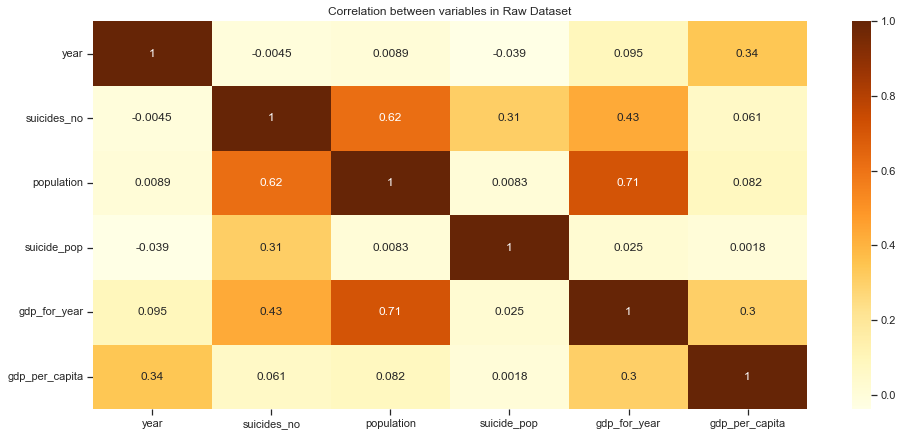

In [8]:
plt.figure(figsize=(16,7))
plt.title("Correlation between variables in Raw Dataset")
cor = sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), cmap='YlOrBr', annot = True) ;

The relationship between numerical factors and suicide rates is weak. Initially, population and suicide numbers show a moderate correlation (0.62), but after adjusting for population size, the true correlation is minimal (0.0083).

/var/folders/8c/f79_3ppx1r59rycv6tkm4flh0000gn/T/ipykernel_81725/1278711810.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = sns.heatmap(df_y.corr(), cmap='YlOrBr', annot = True) ;


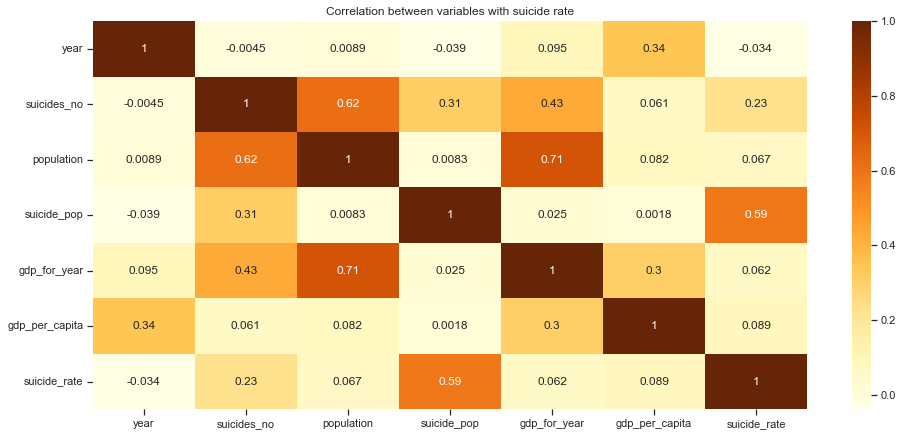

In [9]:
plt.figure(figsize=(16,7))
plt.title("Correlation between variables with suicide rate")
cor = sns.heatmap(df_y.corr(), cmap='YlOrBr', annot = True) ;

Excluding suicide_no, population and suicide_pop from the metric since these features are incorporated in suicide_rate metric. gdp_per_capita shows weak correlation.

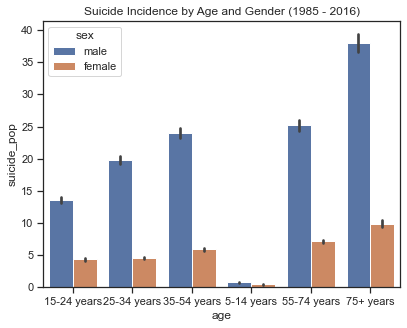

In [10]:
# Create a barplot 
sns.barplot(data=df, x='age', y='suicide_pop', hue='sex', order = sorted(df['age'].unique()))
plt.title('Suicide Incidence by Age and Gender (1985 - 2016)');

Older individuals are more susceptible to suicide. Suicide rates are significantly higher among men compared to women across various age groups, nearly 3-4 times more common.

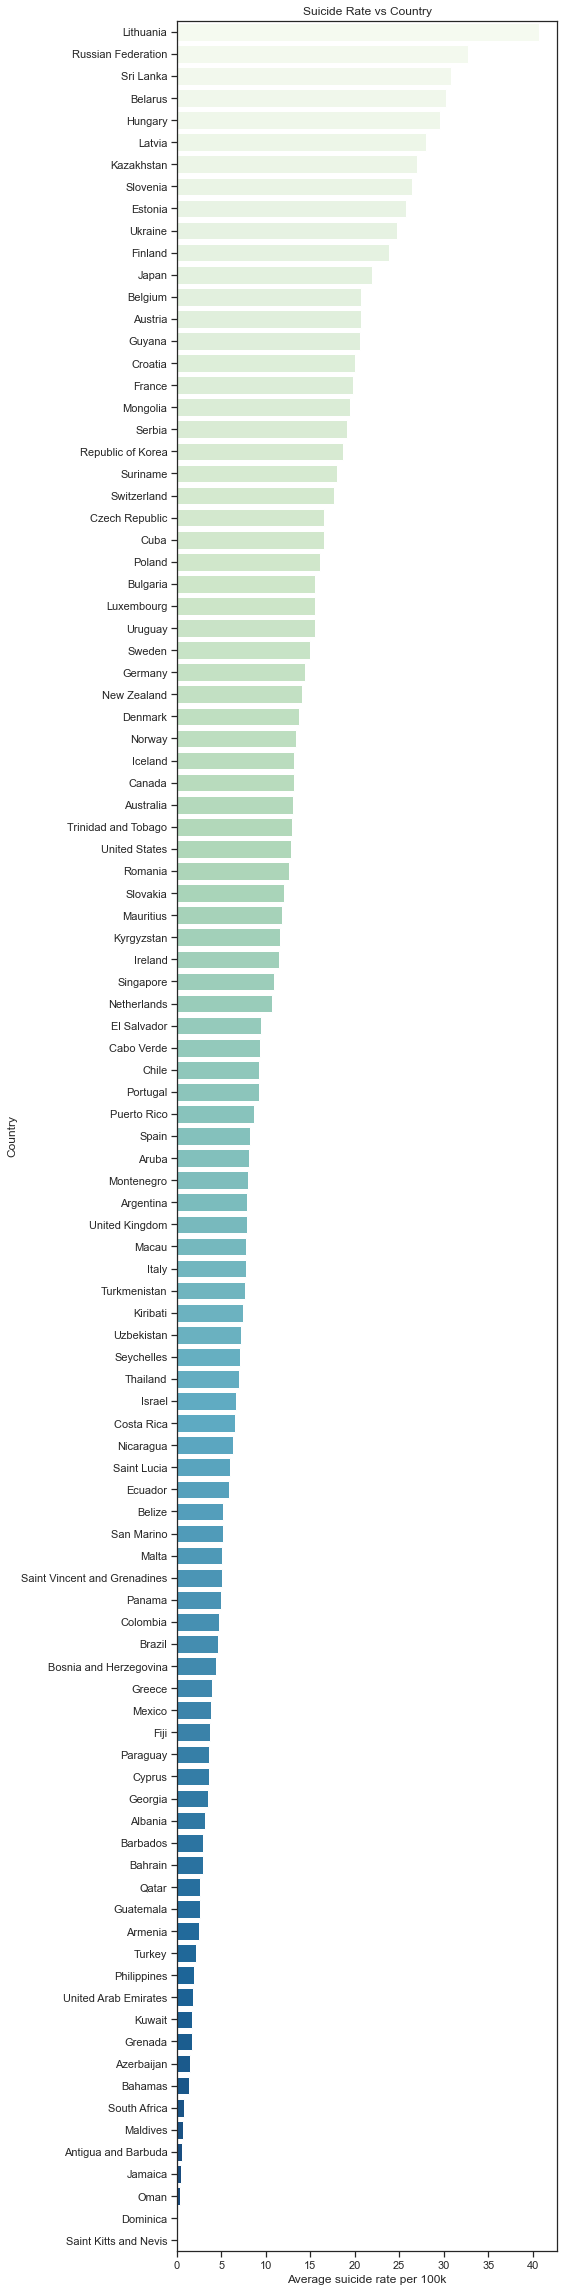

In [11]:
# Calculate the total suicides by country and year
df_suicides_total = df.groupby(["country", "year"])["suicides_no"].sum()

# Calculate the total population by country and year
df_population_total = df.groupby(["country", "year"])["population"].sum()

# Combine the two datasets and calculate the suicide rate per 100k
df_combined = pd.DataFrame({
    'suicides_total': df_suicides_total,
    'population_total': df_population_total
}).reset_index()

# Calculate the suicide rate per 100k by country
df_combined['suicide_rate'] = df_combined.apply(
    lambda row: (row['suicides_total'] / row['population_total']) * 100000, axis=1
)

# Calculate the mean suicide rate per country
df_mean_suicide_rate = df_combined.groupby('country')['suicide_rate'].mean().reset_index()

# Sort the results in descending order
df_mean_suicide_rate_sorted = df_mean_suicide_rate.sort_values('suicide_rate', ascending=False)

# Plotting
plt.figure(figsize=(8, 32))
sns.barplot(
    x='suicide_rate',
    y='country',
    data=df_mean_suicide_rate_sorted,
    palette="GnBu"
)
plt.xlabel("Average suicide rate per 100k")
plt.ylabel("Country")
plt.title("Suicide Rate vs Country")
plt.tight_layout() 
plt.show()

Overall, country wise features show high variability when normalised across year. Multifactorial influence suspected therefore could be significant.

#### Point-Biserial Approach (adapted from https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1)

To find correlation between the categorical variables. Categorical variables show higher correlation.

1.  Positive Associations:

- sex_male: A strong positive correlation
- Age groups: Older age groups (55-74 years, 35-54 years, and 75+ years) are more strongly associated as confirmed by plots.

2. Top Negative Associations:

- sex_female: Strong negative correlation.
- Generations: Millennials and Generation Z suggesting these younger generations less associated with high suicide rates.

In [14]:
categorical_features = ['country', 'sex', 'age', 'generation']
df_dummies = pd.get_dummies(df_y[categorical_features])

df_with_dummies = pd.concat([df_dummies, df_y['suicide_rate']], axis=1)

# Calculating point-biserial correlations between dummy variables and 'suicide_rate'
correlations_dummies = df_with_dummies.corr()['suicide_rate'].sort_values(ascending=False)
correlations_dummies = correlations_dummies[correlations_dummies.index != 'suicide_rate']

# Displaying the correlations
correlations_dummies.head(10), correlations_dummies.tail(10)  # Showing top and bottom 10 for brevity

(sex_male                      0.362617
 generation_Silent             0.147521
 age_55-74 years               0.138955
 generation_Boomers            0.129428
 age_35-54 years               0.129314
 age_75+ years                 0.124301
 generation_G.I. Generation    0.115344
 country_Japan                 0.071386
 country_Kazakhstan            0.071030
 country_Russian Federation    0.069049
 Name: suicide_rate, dtype: float64,
 country_Jamaica               -0.082553
 country_Grenada               -0.085577
 country_Bahamas               -0.087016
 country_South Africa          -0.093257
 country_Antigua and Barbuda   -0.101820
 country_Kuwait                -0.103683
 generation_Millenials         -0.225925
 generation_Generation Z       -0.231948
 sex_female                    -0.362617
 age_5-14 years                -0.440708
 Name: suicide_rate, dtype: float64)


**5.** [20 pts] Pre-process the dataset and list the major features you want to use. Note that not all features are crucial. For example, country-year variable is a derived feature and for a classifier it would not be necessary to include the year, the country and the country -year together. In fact, one must avoid adding a derived feature and the original at the same time. List the independent features you want to use.

**Ans.** 
The columns we'll exclude are:

- `year`: Irrelevant for predicting an individual's future suicide risk.
- `suicides_no, population`: Redundant, given the `suicides/100k pop` column.
- `suicide_pop`: Redundant, as it mirrors `suicide_rate` data.
- `gdp_for_year`: Redundant due to the presence of `gdp_per_capita`.
- `generation`: Redundant, as each generation correlates to a specific age group, already covered by the `age` column.
- `country-year`: Redundant data excluded
- `HDI_for_year`: Excluded for high missing records.

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Dropping variables reasoned as redundant feactures
df_o = df_y.drop(columns=['suicides_no', 'suicide_pop', 'year', 'population', 'gdp_for_year', 'generation'])

# Feature Engineering: Converting 'age' into an ordinal feature
# age_order = {'5-14 years': 0, '15-24 years': 1, '25-34 years': 2, '35-54 years': 3, '55-74 years': 4, '75+ years': 5}
# df_o['age_ordinal'] = df_o['age'].map(age_order)

# # Dropping original 'age' column
# df_o = df_o.drop(columns=['age'])

# Preparing features for normalization and encoding
numerical_features = ['gdp_per_capita']
categorical_features = ['country', 'sex', 'age']

# Normalization for numerical features
numerical_transformer = StandardScaler()

# One-hot encoding for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [16]:
numeric_cols = list(df_o.select_dtypes(include=np.number).columns)
categorical_cols = list(df_o.select_dtypes(include='object').columns)

print('numeric columns: ', numeric_cols)
print('categorical columns: ', categorical_cols)

# Display the new df_o dataset structure and suicide_rate variable
df_o[['suicide_rate'] + numerical_features + categorical_features].head()

numeric columns:  ['gdp_per_capita', 'suicide_rate']
categorical columns:  ['country', 'sex', 'age']


,suicide_rate,gdp_per_capita,country,sex,age
0,1,796,Albania,male,15-24 years
1,0,796,Albania,male,35-54 years
2,0,796,Albania,female,15-24 years
3,0,796,Albania,male,75+ years
4,0,796,Albania,male,25-34 years


**6.** [20 pts] Devise a classification problem and present a working prototype model. (It does not have to perform great, but it has to be functional.) 

Note that we will continue with this problem in the following modules.

In [17]:
# Checking the balance of the target variable
target_balance = df_o['suicide_rate'].value_counts(normalize=True)  # Get the proportion of each class

print("Category balance")
target_balance

Category balance


0    0.500144
1    0.499856
Name: suicide_rate, dtype: float64

Since the both categories are equally represented, we can go for a 80% Random Train-test Split Evaluation for simplicity. However, k-fold cross-validation can also be performed.

Logistic regression is chosen for its binary classification tasks due to its simplicity, interpretability, and efficiency, making it an excellent baseline model. While logistic regression can provide probability estimates for predictions and allows for an easy understanding of feature importance, it may struggle with complex, non-linear relationships and highly correlated features. If logistic regression's performance is deemed insufficient, more complex models could be explored to but at the cost of increased computational complexity and potentially lower interpretability. Therefore, logistic regression is used to establish a baseline.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Preparing the target variable and features
y = df_o['suicide_rate']
X = df_o.drop('suicide_rate', axis=1)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Function to train and test the logistic regression model with preprocessing
def logistic_regression_train_test(_X_tr, _X_ts, _y_tr, _y_ts):
    # Creating a pipeline that first preprocesses the data then applies logistic regression
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', LogisticRegression(max_iter=1000, random_state=42))])
    pipeline.fit(_X_tr, _y_tr)
    y_pred = pipeline.predict(_X_ts)
    
    # Calculating additional metrics
    accuracy = accuracy_score(_y_ts, y_pred)
    precision = precision_score(_y_ts, y_pred)
    recall = recall_score(_y_ts, y_pred)
    f1 = f1_score(_y_ts, y_pred)
    
    return accuracy, precision, recall, f1

# Initial 80% train-test split evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
metrics = logistic_regression_train_test(X_train, X_test, y_train, y_test)

# Run 10 times to observe variability in all metrics
variability_metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    accuracy, precision, recall, f1 = logistic_regression_train_test(X_train, X_test, y_train, y_test)
    
    variability_metrics['Accuracy'].append(accuracy)
    variability_metrics['Precision'].append(precision)
    variability_metrics['Recall'].append(recall)
    variability_metrics['F1 Score'].append(f1)

# Displaying results
for metric, values in variability_metrics.items():
    print(f'Variability in {metric} over 10 runs: {values}')

Variability in Accuracy over 10 runs: [0.8871315600287563, 0.8905463695183321, 0.8846153846153846, 0.8878504672897196, 0.8873112868439971, 0.8865923795830338, 0.8900071890726097, 0.888569374550683, 0.8952192667145938, 0.8901869158878505]
Variability in Precision over 10 runs: [0.8793594306049822, 0.8792982456140351, 0.8658620689655172, 0.8774509803921569, 0.8762993762993763, 0.8716968011126565, 0.8791695030633083, 0.8770775623268698, 0.8887748117727584, 0.8759048603929679]
Variability in Recall over 10 runs: [0.8952898550724637, 0.904366654637315, 0.908465991316932, 0.9014388489208633, 0.9035369774919614, 0.9053810039725533, 0.9095070422535211, 0.9052894924946391, 0.9096322241681261, 0.9101002865329513]
Variability in F1 Score over 10 runs: [0.8872531418312388, 0.8916562889165628, 0.8866525423728813, 0.8892831795599716, 0.8897097625329816, 0.8882196634189548, 0.8940809968847352, 0.8909602532536054, 0.8990825688073394, 0.8926752151765325]


In [20]:
%%time
# Collecting statistics with 100 iterations for all metrics
metrics_results = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    accuracy, precision, recall, f1 = logistic_regression_train_test(X_train, X_test, y_train, y_test)
    
    metrics_results['Accuracy'].append(accuracy)
    metrics_results['Precision'].append(precision)
    metrics_results['Recall'].append(recall)
    metrics_results['F1 Score'].append(f1)

# Calculating and printing average and standard deviation for each metric
for metric, values in metrics_results.items():
    print(f'Average {metric} over 100 repeated runs: {np.mean(values):.3f} ± {np.std(values):.4f}')

Average Accuracy over 100 repeated runs: 0.891 ± 0.0000
Average Precision over 100 repeated runs: 0.879 ± 0.0000
Average Recall over 100 repeated runs: 0.903 ± 0.0000
Average F1 Score over 100 repeated runs: 0.891 ± 0.0000
CPU times: user 26.9 s, sys: 78.3 ms, total: 27 s
Wall time: 27 s
